In [1]:
import copy
import json
import numpy as np
import matplotlib.pyplot as plt

from utils import ConfigObject
from utils import reserve_pop
from utils import id_generator
from utils import writer
from utils import LibriSpeechGenerator

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F

from parts import VSConvBlock
from parts import DownSamplingBlock
from parts import UpSamplingBlock
from parts import OutBlock

## Parameters

In [2]:
jsonConfig = {
    "test_platform": False,
    "ds_prop": 0.25,
    "sr": 16000,
    "n_samples": 65536,
    
    "n_channels": 1,
    "n_classes": 1,
    "depth": 5,
    "fsize": 24,
    "moffset": 8,
    
    "batch_size": 48,
    "epochs": 100,
    "shuffle": True,
    "num_workers": 8,
    "verbose": 100,

    "checkpoint_path": "../models/checkpoint.pt",
    "model_path": "../models/last_model.pt",

    "save_last_batch": True,
    "writer_path": "../logs/",
    "history_path": "../logs/history.json"
}

config = ConfigObject(**jsonConfig)

In [3]:
# Data Loaders
_params = {
    'batch_size': config.batch_size,
    'shuffle': config.shuffle,
    'num_workers': config.num_workers
}

## Import Data

In [4]:
X_train = torch.load("../data/processed/aewi/train/train.pt")
X_val = torch.load("../data/processed/aewi/val/val.pt")

## Data Generators

In [5]:
# Data Generators
lsg = LibriSpeechGenerator(config, X_train, mode="ae")
lsg_val = LibriSpeechGenerator(config, X_val, mode="ae")

ls_generator = data.DataLoader(lsg, **_params)
ls_val_generator = data.DataLoader(lsg_val, **_params)

## Model

In [6]:
class SEWUNet(nn.Module):
    def __init__(self, config, fd=15, fu=5):
        """Speech Enhancenment using Wave-U-Net"""
        super(SEWUNet, self).__init__()

        # Hyperparameters
        self.n_channels = config.n_channels
        self.n_classes = config.n_classes
        self.depth = config.depth
        self.fsize = config.fsize
        self.moffset = config.moffset
        self.fd = fd
        self.fu = fu

        # Generate the list of in, out channels for the encoder
        self.enc_filters = [self.n_channels]
        self.enc_filters += [self.fsize * i + self.moffset
                             for i in range(1, self.depth + 1)]
        self.n_encoder = zip(self.enc_filters, self.enc_filters[1:])

        # Bottleneck block sizes
        mid_in = self.fsize * self.depth + self.moffset
        mid_out = self.fsize * (self.depth + 1) + self.moffset

        # Generate the list of in, out channels for the decoder
        self.out_dec = reserve_pop(self.enc_filters)
        self.in_dec = [mid_out + self.enc_filters[-1]]
        self.in_dec += [self.out_dec[i] + self.out_dec[i + 1]
                        for i in range(self.depth - 1)]
        self.n_decoder = zip(self.in_dec, self.out_dec)

        # Architecture and parameters
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        # Build the encoder part of the U-net architecture
        for i, (in_ch, out_ch) in enumerate(self.n_encoder):
            self.encoder.append(DownSamplingBlock(
                in_ch=in_ch,
                out_ch=out_ch,
                kernel_size=self.fd,
                padding=self.fd // 2,
                activation=nn.LeakyReLU(0.1))
            )

        # Bottleneck block for the U-net
        self.mid_block = VSConvBlock(
            in_ch=mid_in,
            out_ch=mid_out,
            kernel_size=self.fd,
            padding=self.fd // 2,
            activation=nn.LeakyReLU(0.1))

        # Build the decoder part of the U-net architecture
        for in_ch, out_ch in self.n_decoder:
            self.decoder.append(UpSamplingBlock(
                in_ch=in_ch,
                out_ch=out_ch,
                kernel_size=self.fu,
                padding=self.fu // 2,
                activation=nn.LeakyReLU(0.1),
                mode="linear")
            )

        # Output block
        out_ch = self.out_dec[-1] + 1
        self.out_block = OutBlock(
            in_ch=out_ch,
            out_ch=self.n_classes,
            activation=nn.Tanh()
        )

    def forward(self, x):
        """"""
        enc = []
        net_in = copy.copy(x)

        for i in range(self.depth):
            x, xi = self.encoder[i](x)
            enc.append(xi)

        x = self.mid_block(x)

        for i in range(self.depth):
            x = self.decoder[i](x, enc.pop())

        x = self.out_block(x, net_in)

        return x

## Trainer

In [7]:
model = SEWUNet(config)

In [8]:
# Training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
history = {'loss': [], 'SNR': [], 'val_loss': [], 'val_SNR': []}

In [9]:
def CustomMetric():
    """Calculate the SNR of X and Y"""
    def SNR(X, Y):
        n = X.shape[2]
        return torch.mean(10 * torch.log10(
            (torch.norm(Y, dim=2)**2 / n) /
            (torch.norm(X - Y, dim=2)**2 / n)
        ))
    return SNR

In [10]:
# Build optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-6,
    betas=(0.9, 0.999))

# lr_scheduler = torch.optim.lr_scheduler(optimizer)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# Loss and metric
m_loss = nn.L1Loss()
m_snr = CustomMetric()

In [11]:
# Copy model to device
model = model.to(device)

In [12]:
# Calculate the number of trainable parameters in the model
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
sum([np.prod(p.size()) for p in model_parameters])

1139372

In [13]:
# Function to display trainning metrics
def _display_metrics(epoch, it, steps, loss, metric):
    print("Epoch [{:02d}/{:02d}]".format(
        epoch + 1, config.epochs), end=", ")

    print("Step [{:03d}/{:03d}]".format(
        it + 1, steps), end=", ")

    print("Loss: {}, SNR: {}".format(
        loss, metric))

In [14]:
# Train the model over epochs
steps = len(ls_generator)

for epoch in range(config.epochs):
    # training and val metrics for all data
    loss, metric = 0.0, 0.0
    val_loss, val_metric = 0.0, 0.0

    # ======================== Training ============================= #
    for i, (local_batch, local_labels) in enumerate(ls_generator):
        # Transfer to Device
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)

        # Set gradient
        optimizer.zero_grad()

        # Forward pass, backward pass, optimize
        outputs = model(local_batch)
        loss_batch = m_loss(outputs, local_labels)
        batch_metric = m_snr(outputs, local_labels)
        loss_batch.backward()
        optimizer.step()

        # Compute metrics to all batch
        loss += loss_batch.item() * len(local_batch)
        metric += batch_metric.item() * len(local_batch)

        # Print the loss every "verbose" batches
        if (i + 1) % config.verbose == 0:
            _display_metrics(epoch, i, steps,
                loss_batch.item(), batch_metric.item())

    # Compute the statistics of the last epoch and save to history
    history['loss'].append(loss / len(lsg))
    history['SNR'].append(metric / len(lsg))

    # Print Validation statistics
    print(".:. Training metrics =", end=" ")
    print("Loss: {}, SNR: {}".format(loss / len(lsg), metric / len(lsg)))
    
    # ======================= Validation ============================ #
    with torch.no_grad():
        for local_batch, local_labels in ls_val_generator:
            # Transfer to device
            local_batch = local_batch.to(device)
            local_labels = local_labels.to(device)

            # Predict, get loss and metric
            outputs = model(local_batch)
            val_loss += m_loss(outputs, local_labels).item() \
                * len(local_batch)

            val_metric += m_snr(outputs, local_labels).item() \
                * len(local_batch)

        val_loss /= len(lsg_val)
        val_metric /= len(lsg_val)
                
    # Print Validation statistics
    print(".:. Validation metrics =", end=" ")
    print("Loss: {}, SNR: {}".format(val_loss, val_metric))

    # Compute the metrics and loss of last batch and save to history
    history['val_loss'].append(val_loss)
    history['val_SNR'].append(val_metric)
    lr_scheduler.step(val_loss)

Epoch [01/100], Step [100/602], Loss: 0.05871373414993286, SNR: -3.8860230445861816
Epoch [01/100], Step [200/602], Loss: 0.024353602901101112, SNR: 1.4941496849060059
Epoch [01/100], Step [300/602], Loss: 0.019357120618224144, SNR: 3.414375066757202
Epoch [01/100], Step [400/602], Loss: 0.01653040386736393, SNR: 3.8690755367279053
Epoch [01/100], Step [500/602], Loss: 0.013603641651570797, SNR: 6.049432754516602
Epoch [01/100], Step [600/602], Loss: 0.013891865499317646, SNR: 6.460853099822998
.:. Training metrics = Loss: 0.029538707824573875, SNR: 1.775557097458275
.:. Validation metrics = Loss: 0.01493075532706181, SNR: 6.01450013511117
Epoch [02/100], Step [100/602], Loss: 0.012636459432542324, SNR: 6.197272300720215
Epoch [02/100], Step [200/602], Loss: 0.012585346587002277, SNR: 7.237674713134766
Epoch [02/100], Step [300/602], Loss: 0.011551455594599247, SNR: 7.767800331115723
Epoch [02/100], Step [400/602], Loss: 0.012242640368640423, SNR: 7.906096935272217
Epoch [02/100], Step

Epoch [13/100], Step [500/602], Loss: 0.0015135295689105988, SNR: 23.991836547851562
Epoch [13/100], Step [600/602], Loss: 0.0011949427425861359, SNR: 25.44036865234375
.:. Training metrics = Loss: 0.0014500057038088381, SNR: 24.255576886771454
.:. Validation metrics = Loss: 0.0012550104346964774, SNR: 25.0597384606814
Epoch [14/100], Step [100/602], Loss: 0.0013770029181614518, SNR: 23.783132553100586
Epoch [14/100], Step [200/602], Loss: 0.0013231203192844987, SNR: 24.422658920288086
Epoch [14/100], Step [300/602], Loss: 0.0011771477293223143, SNR: 24.22305679321289
Epoch [14/100], Step [400/602], Loss: 0.001398757565766573, SNR: 23.10690689086914
Epoch [14/100], Step [500/602], Loss: 0.0013998759677633643, SNR: 24.922714233398438
Epoch [14/100], Step [600/602], Loss: 0.0009784706635400653, SNR: 26.24969482421875
.:. Training metrics = Loss: 0.0013562838713454919, SNR: 24.731353959867672
.:. Validation metrics = Loss: 0.0010148194792758106, SNR: 25.811238298349974
Epoch [15/100], Ste

Epoch [26/100], Step [100/602], Loss: 0.0007342477329075336, SNR: 28.12886619567871
Epoch [26/100], Step [200/602], Loss: 0.0007155972998589277, SNR: 28.37030029296875
Epoch [26/100], Step [300/602], Loss: 0.0008381966035813093, SNR: 27.646183013916016
Epoch [26/100], Step [400/602], Loss: 0.0006693550967611372, SNR: 29.454526901245117
Epoch [26/100], Step [500/602], Loss: 0.000617196608800441, SNR: 30.773635864257812
Epoch [26/100], Step [600/602], Loss: 0.0007179484236985445, SNR: 28.67856216430664
.:. Training metrics = Loss: 0.000844334061818052, SNR: 28.403391988431213
.:. Validation metrics = Loss: 0.0008219404928026402, SNR: 28.991390529254264
Epoch [27/100], Step [100/602], Loss: 0.0006832375074736774, SNR: 28.850521087646484
Epoch [27/100], Step [200/602], Loss: 0.000880557345226407, SNR: 28.053001403808594
Epoch [27/100], Step [300/602], Loss: 0.0007796382997184992, SNR: 30.471755981445312
Epoch [27/100], Step [400/602], Loss: 0.0008754036389291286, SNR: 27.905380249023438
Ep

Epoch [38/100], Step [500/602], Loss: 0.0006436420371755958, SNR: 30.542320251464844
Epoch [38/100], Step [600/602], Loss: 0.00046320189721882343, SNR: 31.014263153076172
.:. Training metrics = Loss: 0.0005057106132747744, SNR: 30.16782287739387
.:. Validation metrics = Loss: 0.0004425292714898528, SNR: 30.71660794084404
Epoch [39/100], Step [100/602], Loss: 0.0004076382901985198, SNR: 30.39790153503418
Epoch [39/100], Step [200/602], Loss: 0.00046717023360542953, SNR: 30.845420837402344
Epoch [39/100], Step [300/602], Loss: 0.000647170701995492, SNR: 28.732685089111328
Epoch [39/100], Step [400/602], Loss: 0.000664122577290982, SNR: 29.078527450561523
Epoch [39/100], Step [500/602], Loss: 0.0005347509286366403, SNR: 29.659408569335938
Epoch [39/100], Step [600/602], Loss: 0.0003875697439070791, SNR: 30.995681762695312
.:. Training metrics = Loss: 0.0005020379569979897, SNR: 30.21974879134504
.:. Validation metrics = Loss: 0.00043903173633447337, SNR: 30.778243219134044
Epoch [40/100],

.:. Validation metrics = Loss: 0.00041382507673362286, SNR: 31.20742813212063
Epoch [51/100], Step [100/602], Loss: 0.0005423363763839006, SNR: 28.563512802124023
Epoch [51/100], Step [200/602], Loss: 0.0005325688980519772, SNR: 29.413631439208984
Epoch [51/100], Step [300/602], Loss: 0.00029884898685850203, SNR: 33.64718246459961
Epoch [51/100], Step [400/602], Loss: 0.0004426841624081135, SNR: 29.55805015563965
Epoch [51/100], Step [500/602], Loss: 0.000352707487763837, SNR: 30.38687515258789
Epoch [51/100], Step [600/602], Loss: 0.0003966515650972724, SNR: 31.039052963256836
.:. Training metrics = Loss: 0.00046975727809683913, SNR: 30.706717608983368
.:. Validation metrics = Loss: 0.00041478089966377063, SNR: 31.244313849411665
Epoch [52/100], Step [100/602], Loss: 0.0004567427095025778, SNR: 30.52103042602539
Epoch [52/100], Step [200/602], Loss: 0.00045939264236949384, SNR: 30.39308738708496
Epoch [52/100], Step [300/602], Loss: 0.0003767912567127496, SNR: 32.136924743652344
Epoch

Epoch [63/100], Step [300/602], Loss: 0.0004089334106538445, SNR: 32.199527740478516
Epoch [63/100], Step [400/602], Loss: 0.0003985173534601927, SNR: 32.164573669433594
Epoch [63/100], Step [500/602], Loss: 0.00042929232586175203, SNR: 31.45321273803711
Epoch [63/100], Step [600/602], Loss: 0.00033015396911650896, SNR: 33.14774703979492
.:. Training metrics = Loss: 0.00044764863118067644, SNR: 31.07540944548648
.:. Validation metrics = Loss: 0.00038949272786114437, SNR: 31.633675126247123
Epoch [64/100], Step [100/602], Loss: 0.00030743409297429025, SNR: 32.32069778442383
Epoch [64/100], Step [200/602], Loss: 0.0003273625625297427, SNR: 32.01468276977539
Epoch [64/100], Step [300/602], Loss: 0.00045694049913436174, SNR: 31.466022491455078
Epoch [64/100], Step [400/602], Loss: 0.00035825115628540516, SNR: 31.246910095214844
Epoch [64/100], Step [500/602], Loss: 0.00033750187139958143, SNR: 32.0083122253418
Epoch [64/100], Step [600/602], Loss: 0.0005621942109428346, SNR: 29.96823692321

Epoch [75/100], Step [600/602], Loss: 0.00033924367744475603, SNR: 31.31066131591797
.:. Training metrics = Loss: 0.0004306647229160391, SNR: 31.37840992520307
.:. Validation metrics = Loss: 0.0003659644661709241, SNR: 31.93434018028819
Epoch [76/100], Step [100/602], Loss: 0.000626911933068186, SNR: 29.030914306640625
Epoch [76/100], Step [200/602], Loss: 0.0003477738646324724, SNR: 31.133583068847656
Epoch [76/100], Step [300/602], Loss: 0.0003505090717226267, SNR: 31.536787033081055
Epoch [76/100], Step [400/602], Loss: 0.00038164504803717136, SNR: 30.75423240661621
Epoch [76/100], Step [500/602], Loss: 0.00046719680540263653, SNR: 31.86189842224121
Epoch [76/100], Step [600/602], Loss: 0.0003029713116120547, SNR: 31.924312591552734
.:. Training metrics = Loss: 0.00042931074854608343, SNR: 31.401743925378398
.:. Validation metrics = Loss: 0.0003624098441510209, SNR: 31.974940053882477
Epoch [77/100], Step [100/602], Loss: 0.0003702666435856372, SNR: 31.669279098510742
Epoch [77/100]

Epoch [88/100], Step [200/602], Loss: 0.0005004799459129572, SNR: 32.65711975097656
Epoch [88/100], Step [300/602], Loss: 0.0008630871307104826, SNR: 30.517911911010742
Epoch [88/100], Step [400/602], Loss: 0.00046603704686276615, SNR: 31.982769012451172
Epoch [88/100], Step [500/602], Loss: 0.0003338593814987689, SNR: 31.577579498291016
Epoch [88/100], Step [600/602], Loss: 0.00028686129371635616, SNR: 32.91240692138672
.:. Training metrics = Loss: 0.0004151903868221595, SNR: 31.665467437018563
.:. Validation metrics = Loss: 0.00035455570744964763, SNR: 32.24018011143736
Epoch [89/100], Step [100/602], Loss: 0.00036480967537499964, SNR: 31.804906845092773
Epoch [89/100], Step [200/602], Loss: 0.0003680386289488524, SNR: 32.67555618286133
Epoch [89/100], Step [300/602], Loss: 0.0002780030481517315, SNR: 33.745635986328125
Epoch [89/100], Step [400/602], Loss: 0.00041829681140370667, SNR: 30.064693450927734
Epoch [89/100], Step [500/602], Loss: 0.0003479606530163437, SNR: 32.33329010009

Epoch [100/100], Step [500/602], Loss: 0.0006597147439606488, SNR: 30.180410385131836
Epoch [100/100], Step [600/602], Loss: 0.000351812836015597, SNR: 32.38691329956055
.:. Training metrics = Loss: 0.0004034875532211003, SNR: 31.89495943525786
.:. Validation metrics = Loss: 0.00034114208742853295, SNR: 32.454291452535756


In [15]:
# Save the last model
torch.save(model.state_dict(), config.model_path)

In [16]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_batch
}, config.checkpoint_path)

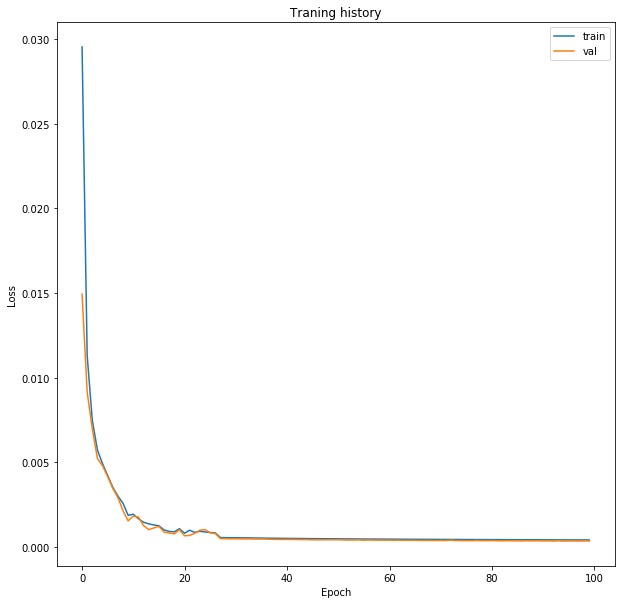

In [17]:
# Plot network history
plt.figure(figsize=(10,10))
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Traning history')
plt.legend()
plt.show()

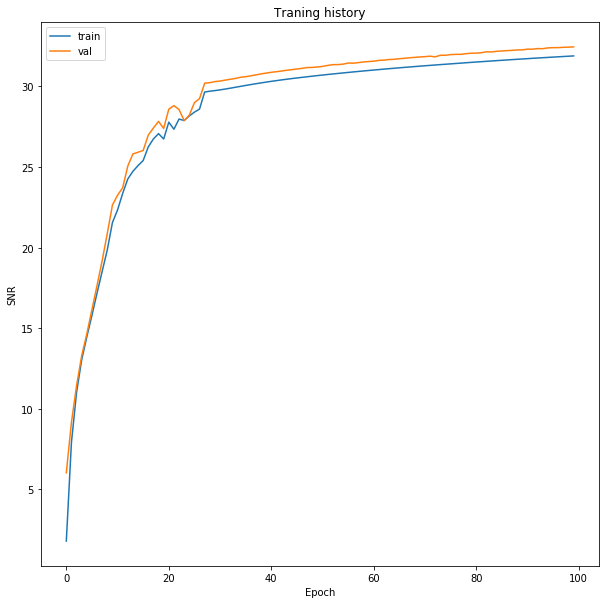

In [18]:
# Plot network history
plt.figure(figsize=(10,10))
plt.plot(history['SNR'], label='train')
plt.plot(history['val_SNR'], label='val')
plt.ylabel('SNR')
plt.xlabel('Epoch')
plt.title('Traning history')
plt.legend()
plt.show()

In [19]:
# Save history to a JSON file
with open(config.history_path, 'w') as fp:
    json.dump(history, fp)

In [20]:
with torch.no_grad():
    for local_batch, local_labels in ls_val_generator:
        # Transfer to device
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)

        # Predict, get loss and metric
        outputs = model(local_batch)
        writer(local_batch, local_labels,
               outputs, config.sr, config.writer_path)